
# < 전력사용량 예측 >
## 회귀 분석과 신경망 모델을 활용한 전력 사용량 예측
### : K-Fold Cross-Validation을 통한 모델 성능 향상

In [1]:
# 폰트 다운로드 (런타임 재부팅 해야함)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,169 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123597 files and dire

In [1]:
# plot 라이브러리
import matplotlib.pyplot as plt
# 경고 메시지 무시
import warnings
# 실행결과 경고메시지 출력 제외
warnings.filterwarnings('ignore')
# 글꼴 설정
plt.rc('font', family='NanumBarunGothic')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import pandas as pd
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.cluster import KMeans
from tqdm import tqdm
import time
import os

import matplotlib.pyplot as plt
import seaborn as sns


#pd.options.display.float_format = '{:.5f}'.format


In [3]:
# 데이터 로드 및 전처리
data = pd.read_csv('train.csv', encoding='euc-kr')
data.isnull().sum() # 결측치확인

,0
num,0
date_time,0
전력사용량(kWh),0
기온(°C),0
풍속(m/s),0
습도(%),0
강수량(mm),0
일조(hr),0
비전기냉방설비운영,0
태양광보유,0


In [4]:
data.describe()

,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
count,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000
mean,30.500000,2324.830866,24.251713,2.151641,80.169848,0.514989,0.213533,0.683333,0.483333
std,17.318173,2058.999326,3.407902,1.514475,15.525862,2.624505,0.370517,0.465178,0.499724
min,1.000000,0.000000,11.100000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,15.750000,1055.268000,21.800000,1.100000,70.000000,0.000000,0.000000,0.000000,0.000000
50%,30.500000,1700.352000,24.200000,1.900000,84.000000,0.000000,0.000000,1.000000,0.000000
75%,45.250000,2780.487000,26.500000,2.900000,93.000000,0.000000,0.300000,1.000000,1.000000
max,60.000000,17739.225000,36.300000,20.100000,100.000000,81.500000,1.000000,1.000000,1.000000


####이상치 파악을 위한 boxplot 시각화

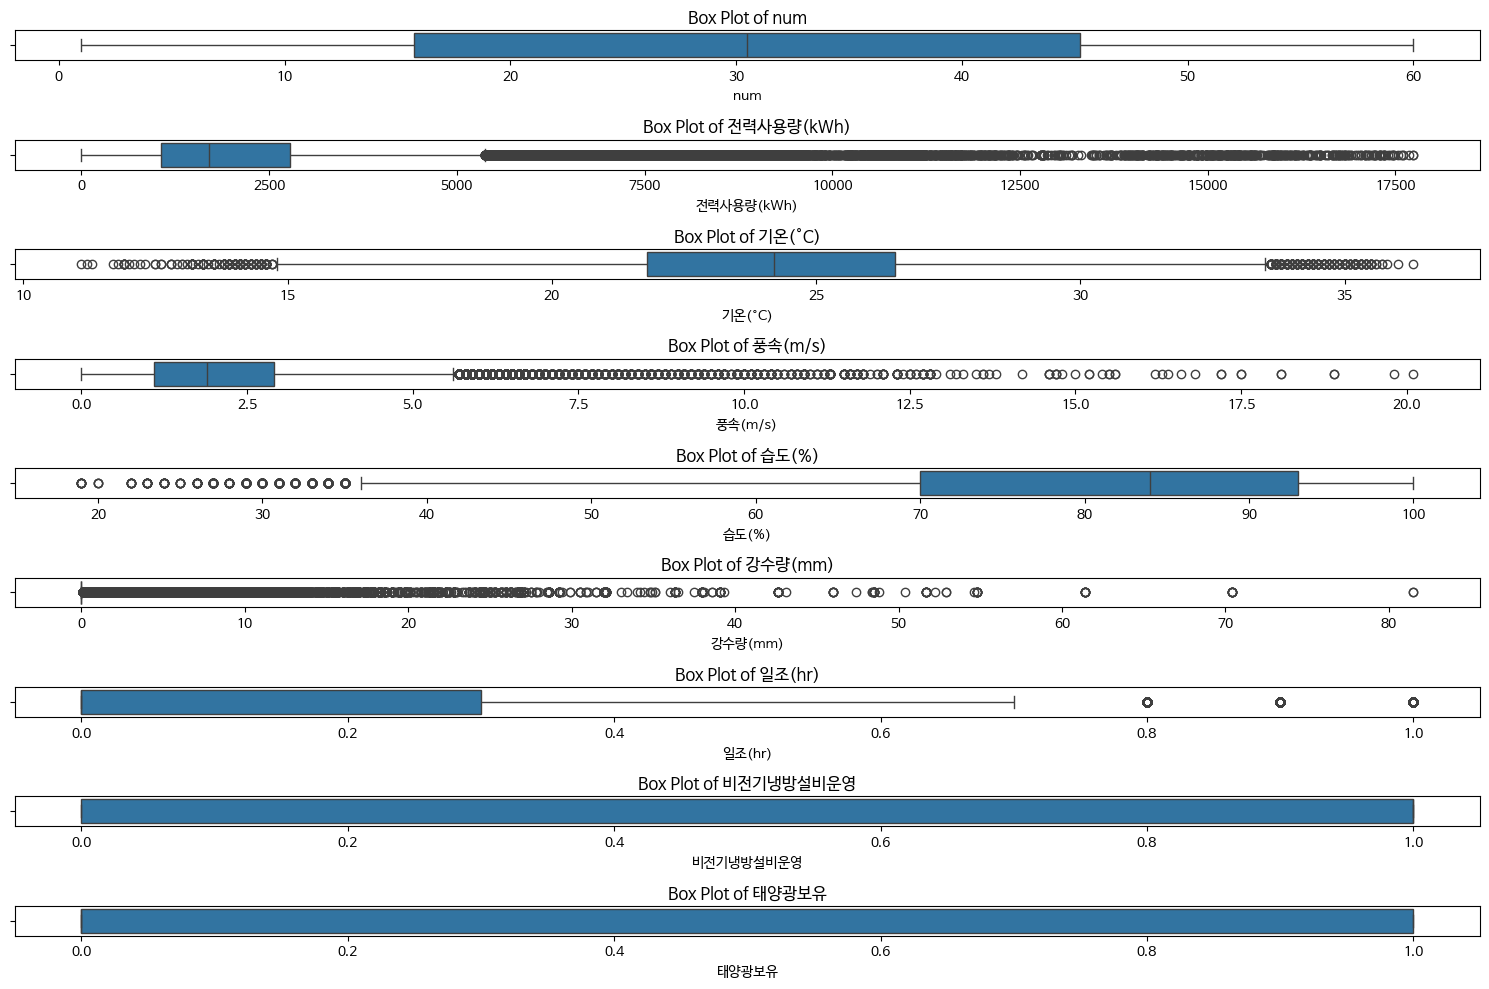

In [5]:
# 컬럼 리스트
columns = data.select_dtypes(include=['number']).columns

# 상자 그림(Box Plot) 그리기
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns, 1):
    plt.subplot(len(columns), 1, i)
    sns.boxplot(x=data[col])
    plt.title(f'Box Plot of {col}')
    plt.tight_layout()

plt.show()

##### boxplot으로 확인해본 결과, 단순 그래프 기반으로 이상치를 판단하기에는 도메인 지식이 부족해서, 전 데이터 바탕으로 분석을 진행했다.

In [7]:
# 'date_time' 열을 datetime 객체로 변환
data['date_time'] = pd.to_datetime(data['date_time'])

# 'date_time' 열의 값을 가장 이른 날짜와의 차이(일 단위)로 변환
# 즉, 가장 이른 날짜를 기준으로 일수로 변환하여 숫자 형태로 표현
data['date_time'] = (data['date_time'] - data['date_time'].min()).dt.days


#### 변수들 간의 관계를 시각화하여 변수들 간의 상관성 파악하기
- pairplot
- 상관관계 heatmap

<Axes: >

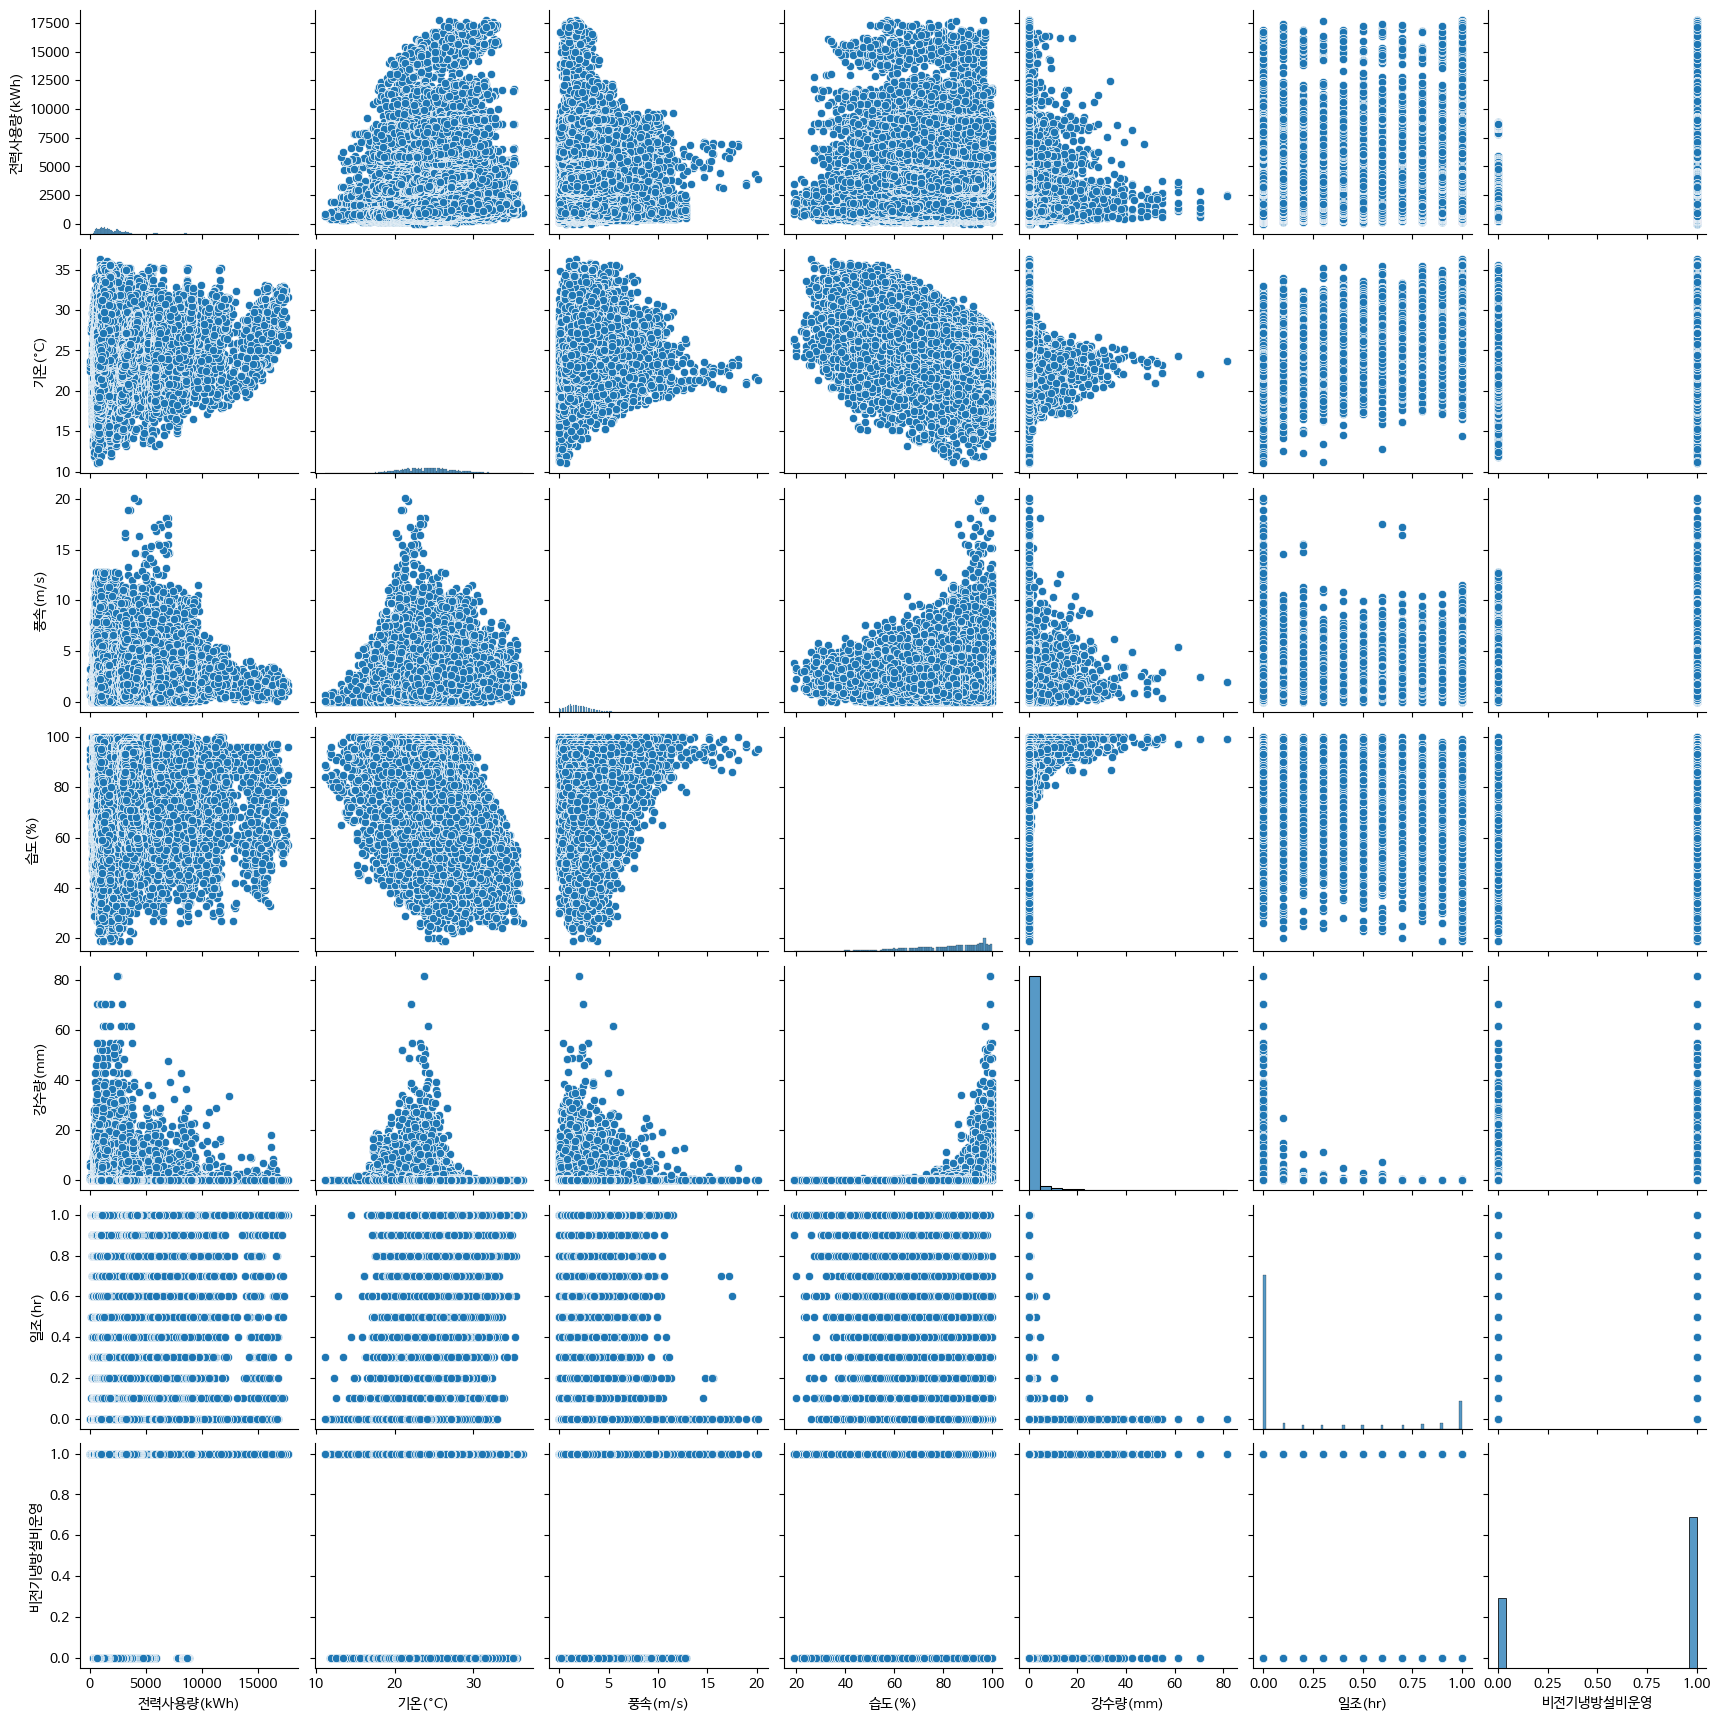

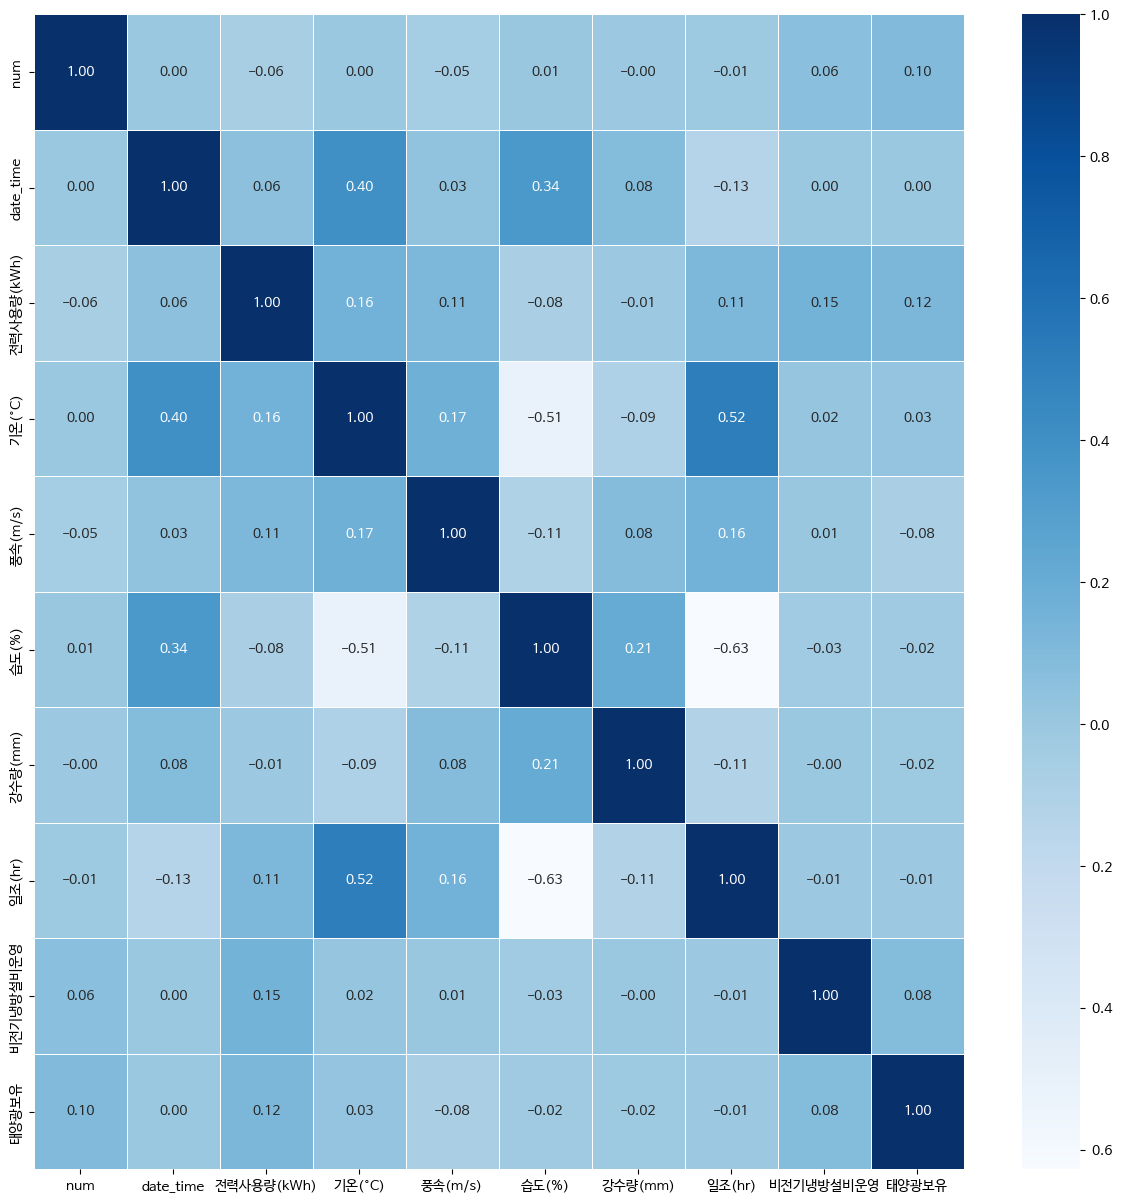

In [8]:
sns.pairplot(data = data, vars = ['전력사용량(kWh)',   '기온(°C)',   '풍속(m/s)',   '습도(%)',   '강수량(mm)',   '일조(hr)',   '비전기냉방설비운영'])
# 상관관계 히트맵
plt.figure(figsize=(15,15))
sns.heatmap(data = data.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

#### 데이터 전처리
- 숫자형 데이터 선택
- 독립 변수, 종속 변수 설정
- KMeans 클러스터링을 통한 파생변수 생성

In [9]:
# 컬럼 리스트 (숫자형 컬럼만 선택)
columns = data.select_dtypes(include=['number']).columns

X = data.drop(columns=['전력사용량(kWh)']).values  # 독립 변수(X) : '전력사용량(kWh)' 열을 제외한 나머지 숫자형 특성
y = data['전력사용량(kWh)'].values  # 종속 변수(y) : 전력사용량(kWh)

# KMeans 클러스터링을 통해 데이터의 군집화를 수행하여 파생변수를 생성
kmeans = KMeans(n_clusters=3, random_state=42) # 데이터를 3개의 군집으로 나누고, 결과의 재현성을 위해 랜덤 시드 42 설정
cluster_labels = kmeans.fit_predict(X) #학습

In [10]:
# 원래 데이터에 클러스터 라벨을 추가하여 확장된 데이터(X_extended)를 생성
X_extended = pd.concat([pd.DataFrame(X), pd.DataFrame(cluster_labels, columns=['cluster'])], axis=1).values
# 데이터 정규화
scaler = StandardScaler()
X_extended[:, :-1] = scaler.fit_transform(X_extended[:, :-1]) # 클러스터 레이블 제외하고 정규화

#### 데이터를 PyTorch 텐서로 변환하는 과정


In [11]:
# 데이터를 PyTorch 텐서로 변환
X_tensor = torch.tensor(X_extended, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)# .view(-1, 1)은 y를 2D 텐서로 변환하여 모델의 출력 형태와 일치시킴

#### DNN(Deep Neural Network) 회귀 모델을 정의

In [12]:
class DNNRegression(nn.Module):
    def __init__(self):
        super(DNNRegression, self).__init__()
        self.layer1 = nn.Linear(X_tensor.shape[1], 64) # 첫 번째 은닉층: 입력 특성 수에서 64개의 유닛으로 변환
        self.bn1 = nn.BatchNorm1d(64)  # 배치 정규화: 첫 번째 은닉층의 출력을 정규화
        # self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(64, 128) # 두 번째 은닉층: 64개의 유닛에서 128개의 유닛으로 변환
        self.bn2 = nn.BatchNorm1d(128)
        # self.dropout2 = nn.Dropout(0.2)
        self.layer3 = nn.Linear(128, 128)# 세 번째 은닉층: 128개의 유닛에서 128개의 유닛으로 변환
        self.bn3 = nn.BatchNorm1d(128)
        # self.dropout3 = nn.Dropout(0.2)
        self.layer4 = nn.Linear(128, 64)   # 네 번째 은닉층: 128개의 유닛에서 64개의 유닛으로 변환
        self.bn4 = nn.BatchNorm1d(64)
        # self.dropout4 = nn.Dropout(0.2)
        self.output_layer = nn.Linear(64, 1) # 출력층: 64개의 유닛에서 1개의 출력으로 변환 (회귀 문제)
        # 가중치 초기화
        self._initialize_weights()

    def forward(self, x):
        #활성화함수 RELU적용 (음수 : 0, 양수 : 1, 학습 속도를 높이고, 더 깊은 네트워크를 학습할 수 있다!)
        x = torch.relu(self.bn1(self.layer1(x)))
        #x = self.dropout1(x)
        x = torch.relu(self.bn2(self.layer2(x)))
        #x = self.dropout2(x)
        x = torch.relu(self.bn3(self.layer3(x)))
        #x = self.dropout3(x)
        x = torch.relu(self.bn4(self.layer4(x)))
        #x = self.dropout4(x)
        x = self.output_layer(x)
        return x

    # 가중치 초기화 함수
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight) # 가중치를 Xavier 초기화 방식(선형 레이어의 가중치를 초기화하는 방법)으로 설정
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

In [13]:
# Hyperparameters
learning_rate = 0.01
weight_decay = 0.1
num_epochs = 10
batch_size = 512

In [14]:
# K-Fold Cross Validation
kf = KFold(n_splits= 5,  shuffle=True, random_state=42) #데이터셋 5개( 4개 : train set, 1개 : valid set → 5번 훈련 평가 반복)
fold = 1 # fold의 번호를 초기화

In [15]:
# Early Stopping 설정
early_stopping_patience = 5 # 모델의 성능이 5 epoch 동안 개선되지 않으면 훈련 중지
early_stopping_counter = 0 #성능 개선이 없는 epoch의 수를 추적하는 카운터
best_loss = float('inf') #모델의 성능이 개선될 때마다 best_loss가 갱신

In [16]:
#  모델 훈련 과정을 기록하기 위한 로그 파일 설정
log_file = "training_log.txt"
if os.path.exists(log_file):
    os.remove(log_file)

In [17]:
# 학습 및 평가

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")# 디바이스 설정 (GPU 또는 CPU) ... 이거할려고 구글코랩쓰는듕
valid_losses = []
for train_index, val_index in kf.split(X_tensor):
    #데이터셋 분할 : 교차 검증(Cross Validation)_K-Fold Cross Validation
    X_train_fold, X_valid_fold = X_tensor[  train_index   ], X_tensor[    val_index   ]
    y_train_fold, y_valid_fold = y_tensor[  train_index   ], y_tensor[    val_index   ]

    # 데이터 로더 생성
    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # 모델, 손실 함수, 옵티마이저 및 스케줄러 설정
    model = DNNRegression().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr= 0.01 , weight_decay= 0.1 )
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 4, gamma = 0.1)

    # 학습 시간 측정 시작
    start_time = time.time()
    early_stopping_counter = 0
    best_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to( device)  # 데이터를 GPU로 이동
            predictions = model(batch_X)
            # 손실 계산
            loss = criterion(predictions, batch_y)
            # 옵티마이저 초기화
            optimizer.zero_grad()
            # 역전파 및 가중치 갱신
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # 학습률 업데이트
        scheduler.step()

        # 평가 손실 계산
        model.eval()
        with torch.no_grad():
            X_valid_fold, y_valid_fold = X_valid_fold.to(device), y_valid_fold.to(device)
            val_predictions = model(X_valid_fold)
            val_loss = criterion(val_predictions, y_valid_fold)

        # log 파일에 정보 기록
        with open(log_file, "a") as f:
            f.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}\n")

        # tqdm 진행 표시줄 업데이트
        tqdm.write(f"Fold {fold}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Valid Loss: {val_loss.item():.4f}")

        # Early Stopping
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            early_stopping_counter = 0
            # 성능이 뛰어날때 마다 모델을 저장
            torch.save(model.state_dict(), "best_model.pth")
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"조기종료 epoch: {epoch+1}")
                break

    # 모델 불러오기 및 평가
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    with torch.no_grad():
        X_valid_fold, y_valid_fold = X_valid_fold.to(device), y_valid_fold.to(device)
        predictions = model(X_valid_fold)
        final_loss = criterion(predictions, y_valid_fold)
        valid_losses.append(criterion(predictions, y_valid_fold))
        print(f"Fold {fold} 평가 손실 Loss: {final_loss.item():.4f}")
        print(f"Fold {fold} 예측 값: {predictions[:5].view(-1).tolist()}")
        print(f"Fold {fold} 실제 값: {y_valid_fold[:5].view(-1).tolist()}")
    fold += 1

# K-Fold의 전체 검증 손실 출력
print(valid_losses)

Fold 1, Epoch 1/10, Loss: 8580449.5286, Valid Loss: 6492222.0000
Fold 1, Epoch 2/10, Loss: 3842057.5710, Valid Loss: 2112119.2500
Fold 1, Epoch 3/10, Loss: 1812397.7549, Valid Loss: 1556170.6250
Fold 1, Epoch 4/10, Loss: 1422283.3008, Valid Loss: 1122798.6250
Fold 1, Epoch 5/10, Loss: 1166542.7461, Valid Loss: 999545.7500
Fold 1, Epoch 6/10, Loss: 1160777.6032, Valid Loss: 979330.3750
Fold 1, Epoch 7/10, Loss: 1131098.3779, Valid Loss: 964053.8750
Fold 1, Epoch 8/10, Loss: 1120227.3730, Valid Loss: 967929.8125
Fold 1, Epoch 9/10, Loss: 1084432.9587, Valid Loss: 944032.5000
Fold 1, Epoch 10/10, Loss: 1092504.5801, Valid Loss: 968851.6250
Fold 1 평가 손실 Loss: 944032.5000
Fold 1 예측 값: [8725.2783203125, 8726.4306640625, 8460.4091796875, 8304.9638671875, 8533.033203125]
Fold 1 실제 값: [8179.05615234375, 8048.80810546875, 7945.1279296875, 7836.912109375, 7989.83984375]
Fold 2, Epoch 1/10, Loss: 8518816.7005, Valid Loss: 6389377.5000
Fold 2, Epoch 2/10, Loss: 3958453.0462, Valid Loss: 2173271.750

In [19]:
import numpy as np

# valid_losses는 리스트이고 그 안에 있는것들이 cpu 이다.
# 즉, 각 손실 값이 PyTorch의 tensor 객체이므로 이를 NumPy 배열로 변환하기 위해 cpu().numpy() 메서드를 사용
valid_losses_np = [loss.cpu().numpy() for loss in valid_losses]

print(f'\n평균 평가 손실: {np.mean(valid_losses_np):.4f}')


평균 평가 손실: 962554.3750


#  위 코드에서 어떤 기법들을 썼었고 왜 그것들을 썼는지 서술 하시오.

## 1. 스탠다드스케일링 사용
DNNRegression은 심층 신경망을 사용하여 회귀 문제를 해결하는 모델이다. 즉, 신경망 모델을 사용한 경우이고, **신경망은 데이터의 스케일에 민감한 알고리즘**이기 때문에, 스탠다드 스케일링을 수행하였다.

## 2. 은닉층 한 층 제거 (모델 단순화)
모델을 단순화하여 모델의 일반화 성능이 개선되었다.
(이번 경우에는 줄었지만, 모델 단순화가 항상 LOSS 가 감소하는 것은 아니다!!)

## 3. 드롭아웃 설정 제거
더 많은 학습이 필요하다고 생각되어 드롭아웃 0.5로 설정되어있었던 것을 주석처리해두었다.

## 4. learning_rate = 0.001 → 0.01
Loss 값이 너무 천천히 감소해서 0.01로 변경하였다. (너무 큰값은 학습이 불안정해지니 주의해야함!!)

## 5. step_size = 2 → 4
기존에는 step_size = 2여서 2 에포크마다 학습률이 감소했다.
변경 후에는, step_size = 4로 변경해서 4 에포크마다 학습률이 감소하게 되어 LOSS가 줄었다.

## 6. batch_size = 64 → 512
배치 크기를 늘려서 학습 속도도 빨라졌다.